In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.nn import Sequential, ReLU, Linear, Conv1d, LSTM, RNN, Dropout
from torch.nn import Module
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor   
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

from NCP.model import DeepSVD
from NCP.layers import SingularLayer, MLPOperator

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)  

np.random.seed(0)
torch.manual_seed(0)
Ntrain = 50000
Nval = 1000
Ntest = 1000

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Heteroscedastic

We study the ability of our method to learn conditional distributions using the following toy example:
$ Y \sim \mathcal{N}(X^2, 1+\vert X \vert)$

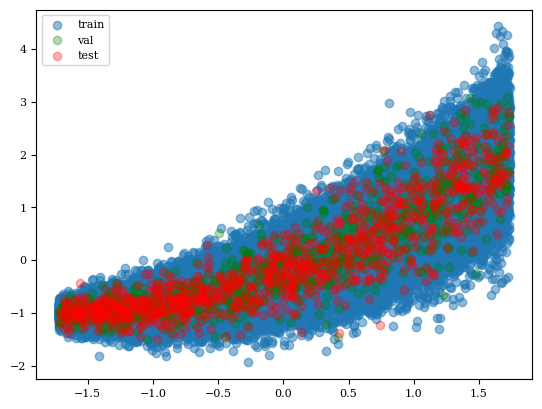

In [3]:
X = np.random.uniform(0, 5, Ntrain+Nval+Ntest)
Y = np.zeros(X.shape[0])
for i, xi in enumerate(X):
    Y[i] = xi**2 + np.random.normal(0, 1+xi)

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()
# Xtransformed = X - X.mean()
# Ytransformed = Y - Y.mean()

Xtransformed = xscaler.fit_transform(X)
Ytransformed = yscaler.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(Xtransformed, Ytransformed, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

We train our model using two MLP for $U_\theta$ and $V_\theta$.

epoch = 9999, loss = -1.616502046585083: 100%|██████████| 10000/10000 [04:10<00:00, 39.90it/s]


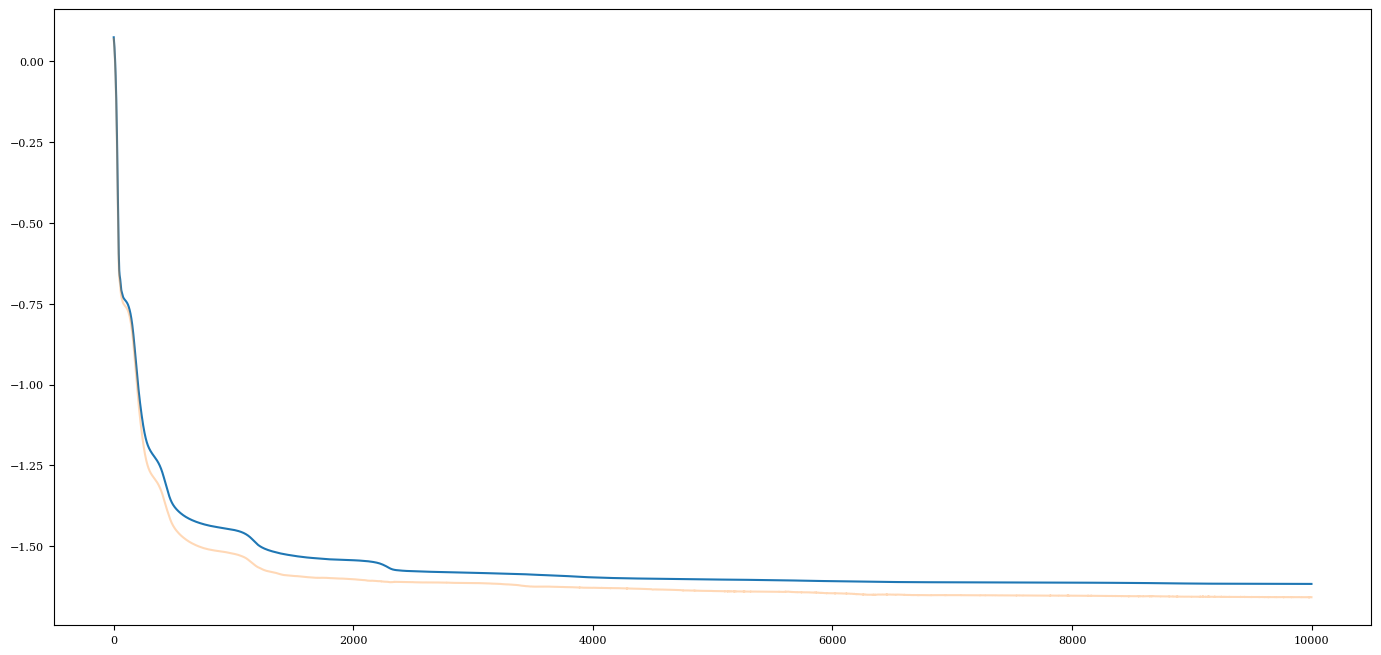

In [4]:
np.random.seed(0)
torch.manual_seed(0)

input_shape = X_train.shape[-1]
output_shape = 10
n_hidden = 2
layer_size = [16,16] # layer size of hidden layers.

U_operator = MLPOperator(input_shape, n_hidden, layer_size, output_shape)
V_operator = MLPOperator(input_shape, n_hidden, layer_size, output_shape)

optimizer = Adam
optimizer_kwargs = {
    'lr': 1e-3
    }
reg = (DeepSVD(U_operator, V_operator, output_shape, gamma=0.01))

reg.fit(X_train, Y_train, X_val, Y_val, epochs=int(1e4), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)

ls = reg.get_losses()
plt.figure(figsize=(17, 8))
plt.plot(range(len(ls)), np.array(ls))
plt.plot(range(len(ls)), np.array(reg.get_val_losses()), alpha=0.3)
# plt.yscale('log')
plt.show()

As we can see, the loss converges. Let us first verify that we are able to predict the expectation of the model:

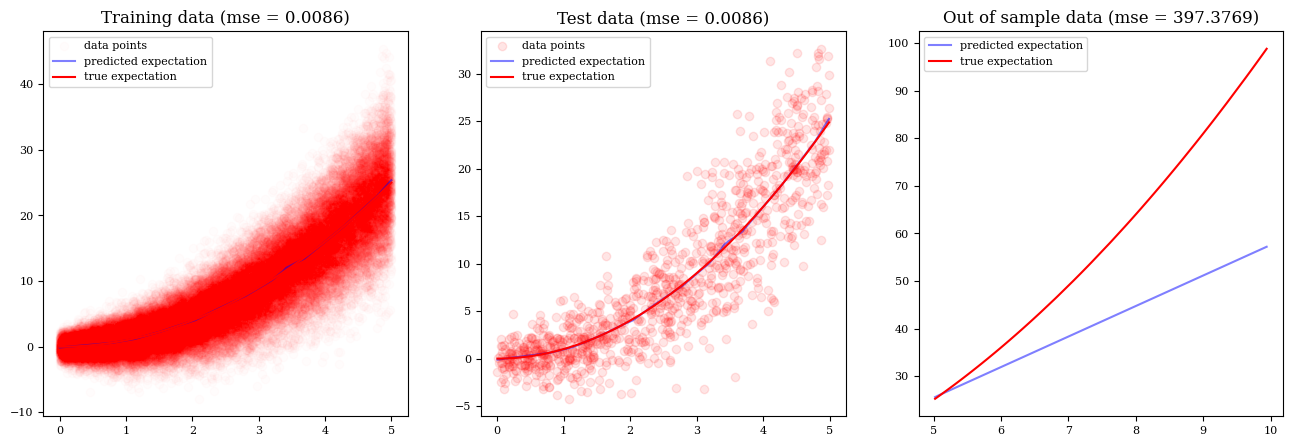

In [5]:
postprocess = 'whitening'

pred = reg.predict(X_train, postprocess=postprocess).reshape(-1, 1)
pred_test = reg.predict(X_test, postprocess=postprocess).reshape(-1, 1)

X_out_of_sample = xscaler.transform(np.random.uniform(5,10, size=100).reshape(-1,1))
pred_oos = reg.predict(X_out_of_sample, postprocess=postprocess).reshape(-1, 1)

fig, axs = plt.subplots(ncols=3, figsize=(16, 5))
axes = axs.flatten()

Xs = xscaler.inverse_transform(X_train)
sorted = np.argsort(Xs.flatten())
axes[0].scatter(Xs, 
                yscaler.inverse_transform(Y_train), 
                color='r', alpha=0.01)
axes[0].plot(Xs.flatten()[sorted], 
             yscaler.inverse_transform(pred).flatten()[sorted], 'b', alpha=0.5)
axes[0].plot(Xs.flatten()[sorted], Xs.flatten()[sorted]**2, 'red')
axes[0].legend(['data points', 'predicted expectation', 'true expectation'])
axes[0].set_title(f'Training data (mse = {round(mean_squared_error(Xs**2, yscaler.inverse_transform(pred)), 4)})')

Xs = xscaler.inverse_transform(X_test)
sorted = np.argsort(Xs.flatten())
axes[1].scatter(Xs, 
                yscaler.inverse_transform(Y_test), 
                color='r', alpha=0.1)
axes[1].plot(Xs.flatten()[sorted], 
             yscaler.inverse_transform(pred_test).flatten()[sorted], 'b', alpha=0.5)
axes[1].plot(Xs.flatten()[sorted], Xs.flatten()[sorted]**2, 'red')
axes[1].legend(['data points', 'predicted expectation', 'true expectation'])
axes[1].set_title(f'Test data (mse = {round(mean_squared_error(Xs**2, yscaler.inverse_transform(pred_test)), 4)})')

Xs = xscaler.inverse_transform(X_out_of_sample)
sorted = np.argsort(Xs.flatten())
axes[2].plot(Xs.flatten()[sorted], 
             yscaler.inverse_transform(pred_oos).flatten()[sorted], 'b', alpha=0.5)
axes[2].plot(Xs.flatten()[sorted], Xs.flatten()[sorted]**2, 'red')
axes[2].legend(['predicted expectation', 'true expectation'])
axes[2].set_title(f'Out of sample data (mse = {round(mean_squared_error(Xs**2, yscaler.inverse_transform(pred_oos)), 4)})')

plt.show()

Let us now examine the CDF for varying values of X:

In [10]:
x = np.array([3,4,5,6,3,4,5,6,7])
np.lib.stride_tricks.sliding_window_view(x, 3)[::3]

array([[3, 4, 5],
       [6, 3, 4],
       [5, 6, 7]])

In [34]:
# distances for one dimensional distributions

# all measures take empirical cdfs computed for the same values as input

def hellinger(x,y, fy=None, interv=None, bin_length=1):
    x_hist = np.diff(x.flatten(), prepend=0)
    y_hist = np.diff(y.flatten(), prepend=0) 

    # sliding window in case of too fine discretisation (disabled by default)
    x_swindow = np.lib.stride_tricks.sliding_window_view(x_hist, bin_length)[::bin_length]
    y_swindow = np.lib.stride_tricks.sliding_window_view(y_hist, bin_length)[::bin_length]
    return np.sum((np.sqrt(x_swindow) - np.sqrt(y_swindow))**2)

def kullback_leibler(x,y, fy=None, interv=None, bin_length=1):
    x_hist = np.diff(x.flatten(), prepend=0)
    y_hist = np.diff(y.flatten(), prepend=0)     

    good_vals = (x_hist > 0) # security in case of constant section in cdf (may happen for extreme values)

    # sliding window in case of too fine discretisation (disabled by default)
    x_swindow = np.lib.stride_tricks.sliding_window_view(x_hist[good_vals], bin_length)[::bin_length]
    y_swindow = np.lib.stride_tricks.sliding_window_view(y_hist[good_vals], bin_length)[::bin_length]
    return np.sum(x_swindow * (np.log(x_swindow)-np.log(y_swindow)))

def wasserstein1(x,y, fy=None, interv=None):
    x_copy = x.copy()
    y_copy = y.copy()

    good_vals = (x_copy > 0) & (y_copy > 0) & (x_copy >= 1) & (y_copy <= 1)

    x_copy = x_copy[good_vals]
    y_copy = y_copy[good_vals]
    return np.linalg.norm((x.flatten()**-1)-(y.flatten()**-1), ord=1)

In [23]:
from scipy.stats import norm
from NCP.cdf import get_cdf, smooth_cdf
x = 1
x_scaled = torch.Tensor(xscaler.transform([[x]]))
fys, cdf_pred = get_cdf(reg, x_scaled, postprocess='whitening')
fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
true_cdf = norm.cdf(fys, loc=x**2, scale=1+np.abs(x))

In [35]:
cdf_pred = smooth_cdf(fys, cdf_pred) # smooth empirical cdf for computations

print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, bin_length=1)}')
print(f'- Hellinger: {hellinger(cdf_pred, true_cdf, bin_length=1)}')
print(f'- Wasserstein: {wasserstein1(cdf_pred, true_cdf)}')

- KL: 0.5826801561146268
- Hellinger: 0.22943962553773167
- Wasserstein: 322870.1432383213


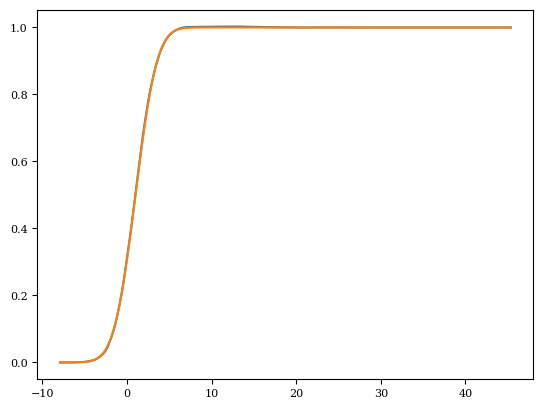

In [102]:
plt.plot(fys, cdf_pred)
plt.plot(fys, true_cdf)

KeyboardInterrupt: 

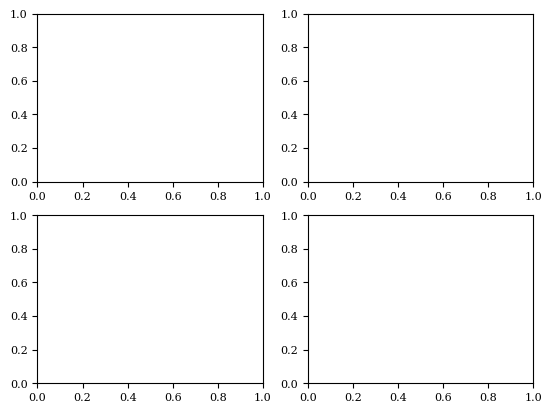

In [21]:
from scipy.stats import norm
from NCP.cdf import get_cdf

fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3, 7]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]]))
    fys, cdf_pred = get_cdf(reg, x_scaled, postprocess=postprocess)
    cdf_pred = smooth_cdf(fys, cdf_pred)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_cdf = norm.cdf(fys, loc=xi**2, scale=1+np.abs(xi))

    # normalising the plots for readability:
    if xi <= 5:
        loc = xi**2
        scale = np.sqrt(1+np.abs(xi))
        plt_interv = [loc - 5*scale, loc+5*scale]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_unscaled = cdf_unscaled[good_fys]
        true_cdf = true_cdf[good_fys]

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    print('result for x=', i)
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys, plt_interv)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf)}')
    print(f'- Wasserstein: {wasserstein1(cdf_pred, true_cdf)}')

plt.show()

Now with whitening:

result for x= 0
- KL: nan
- Hellinger: nan
- Wasserstein: 43719476.19434756


/var/folders/m2/86ygsxzd7m79qj2clmkdp7840000gn/T/ipykernel_346/3664997616.py:21: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist*np.log(y_hist/x_hist))
/var/folders/m2/86ygsxzd7m79qj2clmkdp7840000gn/T/ipykernel_346/3664997616.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)


result for x= 1
- KL: nan
- Hellinger: nan
- Wasserstein: 22093.10022572368


/var/folders/m2/86ygsxzd7m79qj2clmkdp7840000gn/T/ipykernel_346/3664997616.py:21: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist*np.log(y_hist/x_hist))
/var/folders/m2/86ygsxzd7m79qj2clmkdp7840000gn/T/ipykernel_346/3664997616.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)


result for x= 2
- KL: -0.5658936912406696
- Hellinger: 0.2227572986405133
- Wasserstein: 105640.80228581102
result for x= 3
- KL: nan
- Hellinger: nan
- Wasserstein: 73417507632276.22


/var/folders/m2/86ygsxzd7m79qj2clmkdp7840000gn/T/ipykernel_346/3664997616.py:21: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist*np.log(y_hist/x_hist))
/var/folders/m2/86ygsxzd7m79qj2clmkdp7840000gn/T/ipykernel_346/3664997616.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)


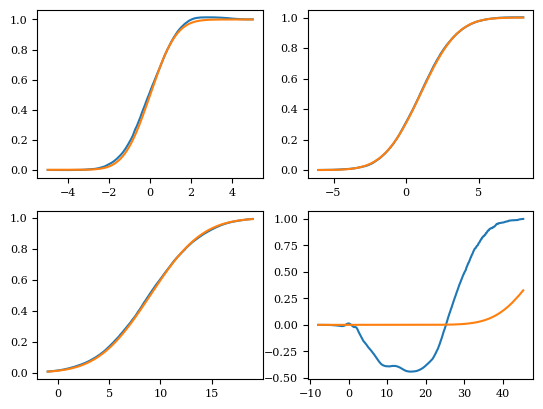

In [68]:
from scipy.stats import norm
from NCP.cdf import get_cdf

fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3, 7]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]]))
    fys, cdf_pred = get_cdf(reg, x_scaled, postprocess='whitening')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()
    cdf_unscaled = cdf_pred

    true_cdf = norm.cdf(fys, loc=xi**2, scale=1+np.abs(xi))

    # normalising the plots for readability:
    if xi <= 5:
        loc = xi**2
        scale = np.sqrt(1+np.abs(xi))
        plt_interv = [loc - 5*scale, loc+5*scale]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_unscaled = cdf_unscaled[good_fys]
        true_cdf = true_cdf[good_fys]

    axes[i].plot(fys, cdf_unscaled)
    axes[i].plot(fys, true_cdf)
    print('result for x=', i)
    print(f'- KL: {kullback_leibler(cdf_unscaled, true_cdf, fys, plt_interv)}')
    print(f'- Hellinger: {hellinger(cdf_unscaled, true_cdf)}')
    print(f'- Wasserstein: {wasserstein1(cdf_unscaled, true_cdf)}')

plt.show()

Estimating variance and other moments: